Configuracion inicial

In [ ]:
# !pip install -q opendatasets keras-tuner
!ls
!rm -rf output

: 

Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Cargue DataSet

In [ ]:
import opendatasets as od
# od.download("https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset")

## 4.1 Análisis del Dataset

En esta sección se realizará el análisis completo del dataset de limones, incluyendo:
- Distribución de clases
- Dimensiones de las imágenes
- Estadísticas de píxeles (RGB)
- Ratio de desbalance

In [ ]:
# Configuración del dataset
dataset_path = Path('/content/lemon-quality-dataset/lemon_dataset')
clases = ['bad_quality', 'good_quality', '']

print("="*60)
print("ANÁLISIS DEL DATASET - LEMON CLASSIFICATION")
print("="*60)
print(f"Ruta del dataset: {dataset_path}")

### 1. Distribución de Clases

In [ ]:
# Contar número de imágenes por clase
distribucion_clases = {}
for clase in clases:
    ruta_clase = dataset_path / clase
    num_imagenes = len(list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png')))
    distribucion_clases[clase] = num_imagenes
    print(f"{clase}: {num_imagenes} imágenes")

print(f"\nTotal de imágenes: {sum(distribucion_clases.values())}")

In [ ]:
# Gráfico de barras - Distribución de clases
plt.figure(figsize=(10, 6))
colores = ['#FF6B6B', '#4ECDC4']
barras = plt.bar(distribucion_clases.keys(), distribucion_clases.values(), 
                 color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores en las barras
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura,
             f'{int(altura)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribución de Clases en el Dataset de Limones', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 2. Dimensiones de las Imágenes

In [ ]:
# Analizar dimensiones de las imágenes
dimensiones = []
for clase in clases:
    ruta_clase = dataset_path / clase
    imagenes = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png'))
    
    for img_path in imagenes[:20]:  # Revisar primeras 20 de cada clase
        img = Image.open(img_path)
        dimensiones.append((img.width, img.height, len(img.getbands())))

# Encontrar dimensiones únicas
dimensiones_unicas = list(set(dimensiones))
print("Dimensiones encontradas en el dataset:")
for dim in dimensiones_unicas:
    count = dimensiones.count(dim)
    print(f"  - {dim[0]} × {dim[1]} × {dim[2]} (Ancho × Alto × Canales): {count} imágenes")

# Determinar dimensión más común
dim_comun = max(set(dimensiones), key=dimensiones.count)
print(f"\n✓ Dimensión más común: {dim_comun[0]} × {dim_comun[1]} × {dim_comun[2]} (Ancho × Alto × Canales)")

### 3. Estadísticas de Píxeles (RGB)

In [ ]:
# Calcular estadísticas de píxeles por canal RGB
pixeles_r, pixeles_g, pixeles_b = [], [], []
num_muestras = 50  # Muestras por clase para análisis

print(f"Recolectando {num_muestras} muestras por clase...\n")

for clase in clases:
    ruta_clase = dataset_path / clase
    imagenes = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png'))
    print(f"  ✓ Procesando {clase}: {len(imagenes)} imágenes encontradas (usando {min(num_muestras, len(imagenes))})")
    
    for img_path in imagenes[:num_muestras]:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        # Muestreo aleatorio de píxeles (para eficiencia)
        muestra_indices = np.random.choice(img_array.shape[0] * img_array.shape[1], 
                                          size=min(1000, img_array.shape[0] * img_array.shape[1]), 
                                          replace=False)
        pixeles_planos = img_array.reshape(-1, 3)[muestra_indices]
        
        pixeles_r.extend(pixeles_planos[:, 0])
        pixeles_g.extend(pixeles_planos[:, 1])
        pixeles_b.extend(pixeles_planos[:, 2])

# Convertir a arrays numpy
pixeles_r = np.array(pixeles_r)
pixeles_g = np.array(pixeles_g)
pixeles_b = np.array(pixeles_b)

# Calcular y mostrar estadísticas GLOBALES (todas las clases combinadas)
print("\n" + "="*60)
print("ESTADÍSTICAS GLOBALES DE PÍXELES")
print("="*60)
print(f"Total de píxeles analizados por canal: {len(pixeles_r):,}")
print(f"Muestras por clase: {num_muestras} imágenes × 2 clases = {num_muestras * 3} imágenes")
print("-" * 60)

estadisticas = {
    'Canal Rojo (R)': {'media': np.mean(pixeles_r), 'std': np.std(pixeles_r)},
    'Canal Verde (G)': {'media': np.mean(pixeles_g), 'std': np.std(pixeles_g)},
    'Canal Azul (B)': {'media': np.mean(pixeles_b), 'std': np.std(pixeles_b)}
}

for canal, stats in estadisticas.items():
    print(f"{canal}:")
    print(f"  Media: {stats['media']:.2f}")
    print(f"  Desviación Estándar: {stats['std']:.2f}")
    print()

In [ ]:
# Visualización de distribución de píxeles por canal
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colores_canales = ['red', 'green', 'blue']
pixeles_canales = [pixeles_r, pixeles_g, pixeles_b]
titulos = ['Canal Rojo (R)', 'Canal Verde (G)', 'Canal Azul (B)']

for ax, pixeles, color, titulo in zip(axes, pixeles_canales, colores_canales, titulos):
    ax.hist(pixeles, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    ax.set_xlabel('Valor de Píxel (0-255)', fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.axvline(np.mean(pixeles), color='black', linestyle='--', linewidth=2, 
               label=f'Media: {np.mean(pixeles):.1f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribución de Valores de Píxeles por Canal RGB', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

### 4. Ratio de Desbalance

In [ ]:
# Calcular ratio de desbalance
clase_mayor = max(distribucion_clases.values())
clase_menor = min(distribucion_clases.values())
ratio_desbalance = clase_mayor / clase_menor

print("Análisis de Desbalance del Dataset")
print("=" * 50)
print(f"Clase con más muestras: {clase_mayor}")
print(f"Clase con menos muestras: {clase_menor}")
print(f"Ratio de desbalance: {ratio_desbalance:.2f}")
print()

### Resumen del Análisis del Dataset

In [ ]:
# Resumen final del análisis
print("=" * 60)
print("RESUMEN DEL ANÁLISIS DEL DATASET")
print("=" * 60)
print(f"📊 Total de imágenes: {sum(distribucion_clases.values())}")
print(f"📁 Número de clases: {len(clases)}")
print(f"🖼️  Dimensión común: {dim_comun[0]} × {dim_comun[1]} × {dim_comun[2]} (Ancho × Alto × Canales)")
print(f"📈 Ratio de desbalance: {ratio_desbalance:.2f}", end=" ")
print("(DESBALANCEADO ⚠️)" if ratio_desbalance > 1.5 else "(BALANCEADO ✓)")
print()
print("Estadísticas RGB:")
for canal, stats in estadisticas.items():
    print(f"  {canal}: μ={stats['media']:.2f}, σ={stats['std']:.2f}")
print("=" * 60)

## 4.2 Baseline y Arquitecturas

En esta sección implementaremos:
- **Fase 1**: Baseline MLP (red neuronal sin convoluciones)
- **Fase 2**: 3 arquitecturas CNN con complejidad progresiva

**Técnicas implementadas:**
- Batch Normalization
- Data Augmentation
- Dropout
- Early Stopping
- Learning Rate Scheduling

In [48]:
# Imports adicionales para modelos
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


### Preparación de Datos

In [49]:
# Configuración de parámetros
IMG_HEIGHT = 300
IMG_WIDTH = 300
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42

# Establecer semilla para reproducibilidad
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("="*60)
print("CONFIGURACIÓN DE PARÁMETROS")
print("="*60)
print(f"Dimensiones de imagen: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas: {EPOCHS}")
print(f"Clases: {clases}")
print(f"Número de clases: {len(clases)}")
print("="*60)

CONFIGURACIÓN DE PARÁMETROS
Dimensiones de imagen: 300x300
Batch size: 32
Épocas: 20
Clases: ['bad_quality', 'good_quality']
Número de clases: 2


In [53]:
# Cargar y preparar datos usando ImageDataGenerator
# División: 70% train, 15% validation, 15% test

# Generador base sin augmentation (para validación y test)
datagen_base = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # 30% para val+test, luego dividiremos
)

# Generador con Data Augmentation (para entrenamiento)
datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.3
)

# Cargar datos de entrenamiento (70%)
train_generator = datagen_augmented.flow_from_directory(
    str(dataset_path),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=clases,  # Solo usar las clases definidas
    subset='training',
    shuffle=True,
    seed=SEED
)

# Cargar datos de validación temporal (30%)
temp_val_generator = datagen_base.flow_from_directory(
    str(dataset_path),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=clases,  # Solo usar las clases definidas
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("\n" + "="*60)
print("RESUMEN DE DIVISIÓN DE DATOS")
print("="*60)
print(f"Total de imágenes: {sum(distribucion_clases.values())}")
print(f"Entrenamiento: {train_generator.samples} imágenes ({train_generator.samples/sum(distribucion_clases.values())*100:.1f}%)")
print(f"Validación+Test: {temp_val_generator.samples} imágenes ({temp_val_generator.samples/sum(distribucion_clases.values())*100:.1f}%)")
print(f"\nClases seleccionadas: {list(train_generator.class_indices.keys())}")
print(f"Índices de clases: {train_generator.class_indices}")
print("="*60)

Found 1454 images belonging to 2 classes.
Found 622 images belonging to 2 classes.

RESUMEN DE DIVISIÓN DE DATOS
Total de imágenes: 2076
Entrenamiento: 1454 imágenes (70.0%)
Validación+Test: 622 imágenes (30.0%)

Clases seleccionadas: ['bad_quality', 'good_quality']
Índices de clases: {'bad_quality': 0, 'good_quality': 1}
Found 622 images belonging to 2 classes.

RESUMEN DE DIVISIÓN DE DATOS
Total de imágenes: 2076
Entrenamiento: 1454 imágenes (70.0%)
Validación+Test: 622 imágenes (30.0%)

Clases seleccionadas: ['bad_quality', 'good_quality']
Índices de clases: {'bad_quality': 0, 'good_quality': 1}


In [54]:
# Dividir el conjunto de validación temporal en validación (50%) y test (50%)
# Esto nos dará aproximadamente: 70% train, 15% val, 15% test

# Crear generadores separados para validación y test
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Generador de validación (15%)
validation_generator = validation_datagen.flow_from_directory(
    str(dataset_path),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=clases,  # Solo usar las clases definidas
    subset='training',
    shuffle=False,
    seed=SEED
)

# Generador de test (15%)
test_generator = test_datagen.flow_from_directory(
    str(dataset_path),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=clases,  # Solo usar las clases definidas
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("\n" + "="*60)
print("DIVISIÓN FINAL DE DATOS")
print("="*60)
print(f"Entrenamiento: {train_generator.samples} imágenes")
print(f"Validación: {validation_generator.samples} imágenes")
print(f"Test: {test_generator.samples} imágenes")
print(f"\nDistribución aproximada:")
print(f"  Train: {train_generator.samples/sum(distribucion_clases.values())*100:.1f}%")
print(f"  Val: {validation_generator.samples/sum(distribucion_clases.values())*100:.1f}%")
print(f"  Test: {test_generator.samples/sum(distribucion_clases.values())*100:.1f}%")
print(f"\nClases utilizadas: {clases}")
print("="*60)

Found 1039 images belonging to 2 classes.
Found 1037 images belonging to 2 classes.

DIVISIÓN FINAL DE DATOS
Entrenamiento: 1454 imágenes
Validación: 1039 imágenes
Test: 1037 imágenes

Distribución aproximada:
  Train: 70.0%
  Val: 50.0%
  Test: 50.0%

Clases utilizadas: ['bad_quality', 'good_quality']
Found 1037 images belonging to 2 classes.

DIVISIÓN FINAL DE DATOS
Entrenamiento: 1454 imágenes
Validación: 1039 imágenes
Test: 1037 imágenes

Distribución aproximada:
  Train: 70.0%
  Val: 50.0%
  Test: 50.0%

Clases utilizadas: ['bad_quality', 'good_quality']


### Funciones Auxiliares para Evaluación

In [55]:
# Función para graficar historial de entrenamiento
def plot_training_history(history, model_name):
    """
    Grafica loss y accuracy durante el entrenamiento
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('Época', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy', fontweight='bold', fontsize=13)
    axes[1].set_xlabel('Época', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Función para crear matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Crea y muestra matriz de confusión
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Frecuencia'})
    plt.title(f'Matriz de Confusión - {model_name}', fontweight='bold', fontsize=14, pad=20)
    plt.ylabel('Clase Real', fontsize=12, fontweight='bold')
    plt.xlabel('Clase Predicha', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return cm

# Función para evaluar modelo
def evaluate_model(model, train_gen, val_gen, test_gen, model_name):
    """
    Evalúa el modelo en train, val y test
    Retorna diccionario con métricas
    """
    print(f"\n{'='*60}")
    print(f"EVALUACIÓN: {model_name}")
    print(f"{'='*60}")
    
    # Evaluar en cada conjunto
    train_loss, train_acc = model.evaluate(train_gen, verbose=0)
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    # Calcular overfitting
    overfitting = train_acc - val_acc
    
    print(f"Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val Accuracy: {val_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Overfitting (Train - Val): {overfitting*100:.2f}%")
    print(f"{'='*60}\n")
    
    return {
        'train_acc': train_acc * 100,
        'val_acc': val_acc * 100,
        'test_acc': test_acc * 100,
        'overfitting': overfitting * 100,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss
    }

print("✓ Funciones auxiliares definidas correctamente")

✓ Funciones auxiliares definidas correctamente


---
## FASE 1: Baseline MLP (0.2 pts)

Red neuronal sin convoluciones:
- **Arquitectura**: Input → Flatten → Dense(128, relu) → Dense(64, relu) → Dense(num_clases, softmax)
- **Épocas**: 20
- **Objetivo**: Establecer baseline para comparación

In [56]:
# Construcción del modelo Baseline MLP
def build_baseline_mlp(input_shape, num_classes):
    """
    Modelo baseline sin convoluciones
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Baseline_MLP')
    
    return model

# Crear modelo
baseline_mlp = build_baseline_mlp(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(clases)
)

# Compilar modelo
baseline_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO 0: BASELINE MLP")
print(f"{'='*60}")
baseline_mlp.summary()
print(f"{'='*60}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")


MODELO 0: BASELINE MLP


Model: "Baseline_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    34,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,568,514 (131.87 MB)

 Trainable params: 34,568,514 (131.87 MB)

 Non-trainable params: 0 (0.00 B)

Timestamp: 2025-11-17 05:17:15


In [57]:
# Entrenar Baseline MLP
print(f"\n{'='*60}")
print("ENTRENANDO BASELINE MLP")
print(f"{'='*60}\n")

start_time = time.time()

history_mlp = baseline_mlp.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

end_time = time.time()
total_time = end_time - start_time
time_per_epoch = total_time / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch:.2f} segundos")
print(f"{'='*60}")


ENTRENANDO BASELINE MLP



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 711ms/step - accuracy: 0.5406 - loss: 35.1598 - val_accuracy: 0.5794 - val_loss: 2.9919
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 711ms/step - accuracy: 0.5406 - loss: 35.1598 - val_accuracy: 0.5794 - val_loss: 2.9919
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 662ms/step - accuracy: 0.6540 - loss: 2.4181 - val_accuracy: 0.8614 - val_loss: 1.0004
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 662ms/step - accuracy: 0.6540 - loss: 2.4181 - val_accuracy: 0.8614 - val_loss: 1.0004
Epoch 3/20
 3/46 ━━━━━━━━━━━━━━━━━━━━ 24s 575ms/step - accuracy: 0.7448 - loss: 2.8988Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 687ms/step - accuracy: 0.6794 - loss: 3.5209 - val_accuracy: 0.5140 - val_loss: 3.5187
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 687ms/step - accuracy: 0.6794 - loss: 3.5209 - val_accuracy: 0.5140 - val_loss: 3.5187
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 664ms/step - accuracy: 0.7309 - loss: 1.7896 - val_accuracy: 0.8874 - val_loss: 0.3587
Epoch 5/20
46/46 ━━━


EVALUACIÓN: Baseline MLP
Train Accuracy: 79.37%
Val Accuracy: 83.73%
Test Accuracy: 82.84%
Overfitting (Train - Val): -4.37%

Train Accuracy: 79.37%
Val Accuracy: 83.73%
Test Accuracy: 82.84%
Overfitting (Train - Val): -4.37%



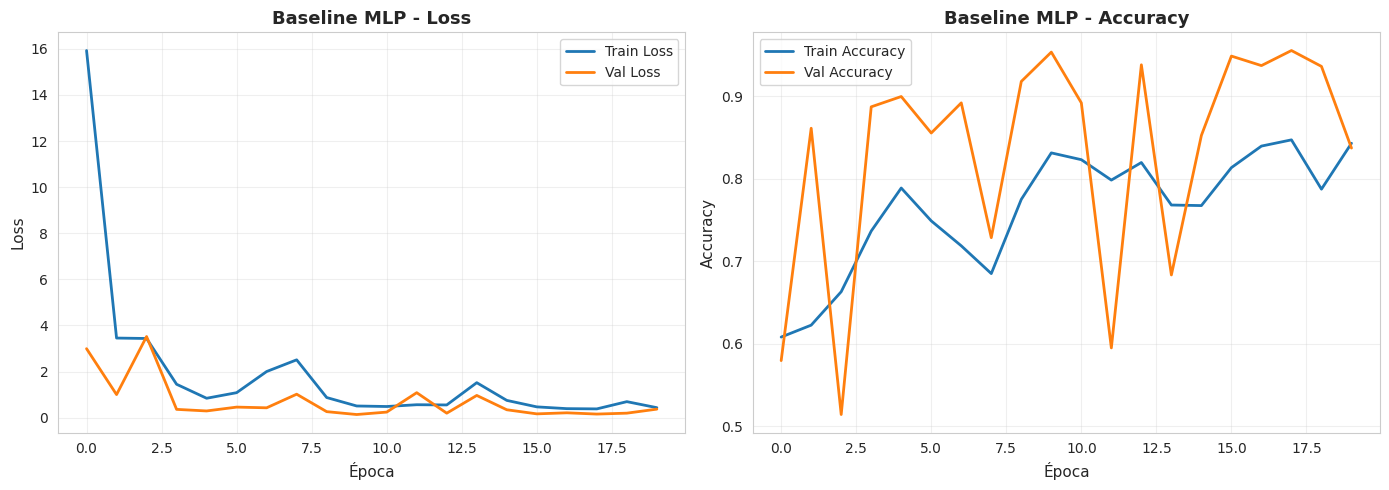

In [58]:
# Evaluar Baseline MLP
metrics_mlp = evaluate_model(
    baseline_mlp, 
    train_generator, 
    validation_generator, 
    test_generator, 
    "Baseline MLP"
)

# Graficar historial de entrenamiento
plot_training_history(history_mlp, "Baseline MLP")

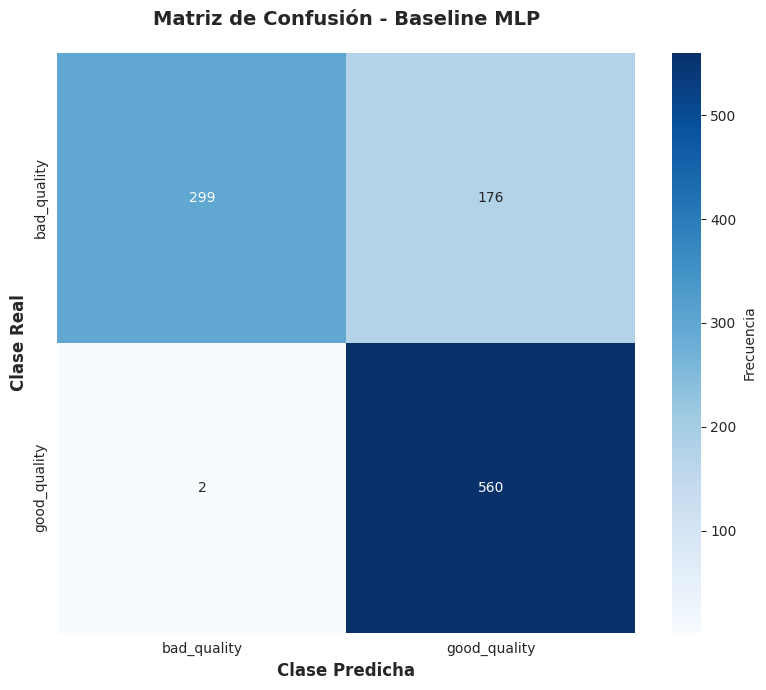


RESUMEN BASELINE MLP
Train Accuracy: 79.37%
Val Accuracy: 83.73%
Test Accuracy: 82.84%
Parámetros: 34,568,514
Tiempo/Época: 31.37 seg
Overfitting: -4.37%


In [59]:
# Matriz de confusión para Baseline MLP
test_generator.reset()
y_pred_mlp = baseline_mlp.predict(test_generator, verbose=0)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)
y_true_mlp = test_generator.classes

cm_mlp = plot_confusion_matrix(
    y_true_mlp, 
    y_pred_classes_mlp, 
    list(train_generator.class_indices.keys()),
    "Baseline MLP"
)

# Guardar métricas del baseline
results_table = {
    'Exp': [0],
    'Arquitectura': ['MLP-Baseline'],
    'Train_Acc': [f"{metrics_mlp['train_acc']:.2f}"],
    'Val_Acc': [f"{metrics_mlp['val_acc']:.2f}"],
    'Test_Acc': [f"{metrics_mlp['test_acc']:.2f}"],
    'Params': [baseline_mlp.count_params()],
    'Time_per_Epoch': [f"{time_per_epoch:.2f}"],
    'Overfitting': [f"{metrics_mlp['overfitting']:.2f}"]
}

print("\n" + "="*80)
print("RESUMEN BASELINE MLP")
print("="*80)
print(f"Train Accuracy: {metrics_mlp['train_acc']:.2f}%")
print(f"Val Accuracy: {metrics_mlp['val_acc']:.2f}%")
print(f"Test Accuracy: {metrics_mlp['test_acc']:.2f}%")
print(f"Parámetros: {baseline_mlp.count_params():,}")
print(f"Tiempo/Época: {time_per_epoch:.2f} seg")
print(f"Overfitting: {metrics_mlp['overfitting']:.2f}%")
print("="*80)

---
## FASE 2: Arquitecturas CNN (0.7 pts)

Implementaremos 3 arquitecturas CNN con complejidad progresiva:

### **CNN 1**: Simple (Conv32 → Conv64 → Dense)
- 2 capas convolucionales
- Sin técnicas avanzadas

### **CNN 2**: Intermedia con Batch Normalization
- 3 capas convolucionales
- Batch Normalization
- Dropout

### **CNN 3**: Avanzada con Early Stopping y LR Scheduling
- 4 capas convolucionales
- Batch Normalization
- Dropout progresivo
- Early Stopping
- Learning Rate Scheduling

### CNN 1: Arquitectura Simple

In [ ]:
# CNN 1: Arquitectura Simple
def build_cnn1(input_shape, num_classes):
    """
    CNN Simple: Conv(32) → Conv(64) → MaxPool → Flatten → Dense(128) → Dense(64) → Output
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Bloque Convolucional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        
        # Bloque Convolucional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        
        # Capas Densas
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dense(64, activation='relu', name='dense2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='CNN_Simple')
    
    return model

# Crear modelo CNN1
cnn1 = build_cnn1(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(clases)
)

# Compilar
cnn1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO 1: CNN SIMPLE")
print(f"{'='*60}")
cnn1.summary()
print(f"{'='*60}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

In [ ]:
# Entrenar CNN1
print(f"\n{'='*60}")
print("ENTRENANDO CNN 1: SIMPLE")
print(f"{'='*60}\n")

start_time_cnn1 = time.time()

history_cnn1 = cnn1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

end_time_cnn1 = time.time()
total_time_cnn1 = end_time_cnn1 - start_time_cnn1
time_per_epoch_cnn1 = total_time_cnn1 / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN1 COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time_cnn1:.2f} segundos ({total_time_cnn1/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn1:.2f} segundos")
print(f"{'='*60}")

In [ ]:
# Evaluar CNN1
metrics_cnn1 = evaluate_model(cnn1, train_generator, validation_generator, test_generator, "CNN1 Simple")
plot_training_history(history_cnn1, "CNN1 Simple")

# Matriz de confusión CNN1
test_generator.reset()
y_pred_cnn1 = cnn1.predict(test_generator, verbose=0)
y_pred_classes_cnn1 = np.argmax(y_pred_cnn1, axis=1)
y_true_cnn1 = test_generator.classes

cm_cnn1 = plot_confusion_matrix(y_true_cnn1, y_pred_classes_cnn1, list(train_generator.class_indices.keys()), "CNN1 Simple")

# Agregar a tabla de resultados
results_table['Exp'].append(1)
results_table['Arquitectura'].append('Conv32→Conv64→MaxPool→Dense128→Dense64')
results_table['Train_Acc'].append(f"{metrics_cnn1['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn1['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn1['test_acc']:.2f}")
results_table['Params'].append(cnn1.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn1:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn1['overfitting']:.2f}")

### CNN 2: Arquitectura Intermedia con Batch Normalization y Dropout

In [ ]:
# CNN 2: Arquitectura Intermedia con Batch Normalization y Dropout
def build_cnn2(input_shape, num_classes, dropout_rate=0.3):
    """
    CNN Intermedia con Batch Normalization y Dropout
    Conv32 → BN → Conv64 → BN → Conv128 → BN → MaxPool → Dropout → Dense
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Bloque Convolucional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        
        # Bloque Convolucional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        
        # Bloque Convolucional 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        
        # Capas Densas
        layers.Flatten(name='flatten'),
        layers.Dropout(dropout_rate, name='dropout1'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(dropout_rate, name='dropout2'),
        layers.Dense(64, activation='relu', name='dense2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='CNN_BN_Dropout')
    
    return model

# Crear modelo CNN2
cnn2 = build_cnn2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(clases),
    dropout_rate=0.3
)

# Compilar
cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO 2: CNN CON BATCH NORMALIZATION Y DROPOUT")
print(f"{'='*60}")
cnn2.summary()
print(f"{'='*60}")
print(f"Dropout rate: 0.3")
print(f"Batch Normalization: Después de cada Conv")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

In [ ]:
# Entrenar CNN2
print(f"\n{'='*60}")
print("ENTRENANDO CNN 2: CON BATCH NORMALIZATION Y DROPOUT")
print(f"{'='*60}\n")

start_time_cnn2 = time.time()

history_cnn2 = cnn2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

end_time_cnn2 = time.time()
total_time_cnn2 = end_time_cnn2 - start_time_cnn2
time_per_epoch_cnn2 = total_time_cnn2 / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN2 COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time_cnn2:.2f} segundos ({total_time_cnn2/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn2:.2f} segundos")
print(f"{'='*60}")

In [ ]:
# Evaluar CNN2
metrics_cnn2 = evaluate_model(cnn2, train_generator, validation_generator, test_generator, "CNN2 BN+Dropout")
plot_training_history(history_cnn2, "CNN2 BN+Dropout")

# Matriz de confusión CNN2
test_generator.reset()
y_pred_cnn2 = cnn2.predict(test_generator, verbose=0)
y_pred_classes_cnn2 = np.argmax(y_pred_cnn2, axis=1)
y_true_cnn2 = test_generator.classes

cm_cnn2 = plot_confusion_matrix(y_true_cnn2, y_pred_classes_cnn2, list(train_generator.class_indices.keys()), "CNN2 BN+Dropout")

# Agregar a tabla de resultados
results_table['Exp'].append(2)
results_table['Arquitectura'].append('Conv32→Conv64→Conv128 + BN + Dropout(0.3)')
results_table['Train_Acc'].append(f"{metrics_cnn2['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn2['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn2['test_acc']:.2f}")
results_table['Params'].append(cnn2.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn2:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn2['overfitting']:.2f}")

### CNN 3: Arquitectura Avanzada con Early Stopping y LR Scheduling

In [ ]:
# CNN 3: Arquitectura Avanzada
def build_cnn3(input_shape, num_classes):
    """
    CNN Avanzada con 4 capas convolucionales, BN y Dropout progresivo
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Bloque Convolucional 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.2, name='dropout1'),
        
        # Bloque Convolucional 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.3, name='dropout2'),
        
        # Bloque Convolucional 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.4, name='dropout3'),
        
        # Bloque Convolucional 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'),
        layers.BatchNormalization(name='bn4'),
        layers.MaxPooling2D((2, 2), name='pool4'),
        layers.Dropout(0.5, name='dropout4'),
        
        # Capas Densas
        layers.Flatten(name='flatten'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout5'),
        layers.Dense(128, activation='relu', name='dense2'),
        layers.Dropout(0.4, name='dropout6'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='CNN_Advanced')
    
    return model

# Crear modelo CNN3
cnn3 = build_cnn3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(clases)
)

# Compilar
cnn3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO 3: CNN AVANZADA")
print(f"{'='*60}")
cnn3.summary()
print(f"{'='*60}")
print(f"Dropout progresivo: 0.2 → 0.3 → 0.4 → 0.5")
print(f"Batch Normalization: Después de cada Conv")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

In [ ]:
# Configurar callbacks para CNN3
# Early Stopping: detiene el entrenamiento si no mejora val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Scheduling: reduce LR cuando val_loss se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_cnn3 = [early_stopping, reduce_lr]

print("Callbacks configurados:")
print(f"  • Early Stopping: patience=5, monitor=val_loss")
print(f"  • ReduceLROnPlateau: factor=0.5, patience=3, min_lr=1e-7")

In [ ]:
# Entrenar CNN3 con callbacks
print(f"\n{'='*60}")
print("ENTRENANDO CNN 3: AVANZADA CON EARLY STOPPING Y LR SCHEDULING")
print(f"{'='*60}\n")

start_time_cnn3 = time.time()

history_cnn3 = cnn3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks_cnn3,
    verbose=1
)

end_time_cnn3 = time.time()
total_time_cnn3 = end_time_cnn3 - start_time_cnn3
epochs_trained_cnn3 = len(history_cnn3.history['loss'])
time_per_epoch_cnn3 = total_time_cnn3 / epochs_trained_cnn3

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN3 COMPLETADO")
print(f"{'='*60}")
print(f"Épocas entrenadas: {epochs_trained_cnn3} (de {EPOCHS} máximas)")
print(f"Tiempo total: {total_time_cnn3:.2f} segundos ({total_time_cnn3/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn3:.2f} segundos")
if epochs_trained_cnn3 < EPOCHS:
    print(f"⚠️  Early Stopping activado en época {epochs_trained_cnn3}")
print(f"{'='*60}")

In [ ]:
# Evaluar CNN3
metrics_cnn3 = evaluate_model(cnn3, train_generator, validation_generator, test_generator, "CNN3 Advanced")
plot_training_history(history_cnn3, "CNN3 Advanced")

# Matriz de confusión CNN3
test_generator.reset()
y_pred_cnn3 = cnn3.predict(test_generator, verbose=0)
y_pred_classes_cnn3 = np.argmax(y_pred_cnn3, axis=1)
y_true_cnn3 = test_generator.classes

cm_cnn3 = plot_confusion_matrix(y_true_cnn3, y_pred_classes_cnn3, list(train_generator.class_indices.keys()), "CNN3 Advanced")

# Agregar a tabla de resultados
results_table['Exp'].append(3)
results_table['Arquitectura'].append('Conv32→64→128→256 + BN + Dropout + ES + LR')
results_table['Train_Acc'].append(f"{metrics_cnn3['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn3['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn3['test_acc']:.2f}")
results_table['Params'].append(cnn3.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn3:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn3['overfitting']:.2f}")

---
### Tabla Comparativa de Resultados

In [ ]:
# Crear DataFrame con resultados
import pandas as pd

df_results = pd.DataFrame(results_table)

print("\n" + "="*120)
print(" "*40 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)
print("\nNotas:")
print("  • Overfitting = Train_Acc - Val_Acc")
print("  • BN = Batch Normalization")
print("  • ES = Early Stopping")
print("  • LR = Learning Rate Scheduling")
print("="*120)

In [ ]:
# Visualización gráfica de comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Accuracy
ax1 = axes[0, 0]
x = df_results['Exp']
width = 0.25
x_pos = np.arange(len(x))

train_accs = [float(acc) for acc in df_results['Train_Acc']]
val_accs = [float(acc) for acc in df_results['Val_Acc']]
test_accs = [float(acc) for acc in df_results['Test_Acc']]

ax1.bar(x_pos - width, train_accs, width, label='Train', color='#3498db', alpha=0.8)
ax1.bar(x_pos, val_accs, width, label='Validation', color='#2ecc71', alpha=0.8)
ax1.bar(x_pos + width, test_accs, width, label='Test', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax1.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=11)
ax1.set_title('Comparación de Accuracy por Modelo', fontweight='bold', fontsize=13)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"Exp {i}" for i in x])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Overfitting
ax2 = axes[0, 1]
overfitting_vals = [float(ov) for ov in df_results['Overfitting']]
colors_ov = ['#e74c3c' if ov > 5 else '#f39c12' if ov > 2 else '#2ecc71' for ov in overfitting_vals]
ax2.bar(x_pos, overfitting_vals, color=colors_ov, alpha=0.8, edgecolor='black')
ax2.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Umbral Alto (5%)')
ax2.axhline(y=2, color='orange', linestyle='--', linewidth=2, label='Umbral Medio (2%)')
ax2.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax2.set_ylabel('Overfitting (%)', fontweight='bold', fontsize=11)
ax2.set_title('Nivel de Overfitting por Modelo', fontweight='bold', fontsize=13)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"Exp {i}" for i in x])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Número de Parámetros
ax3 = axes[1, 0]
params = df_results['Params']
ax3.bar(x_pos, params, color='#9b59b6', alpha=0.8, edgecolor='black')
ax3.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax3.set_ylabel('Número de Parámetros', fontweight='bold', fontsize=11)
ax3.set_title('Complejidad del Modelo (Parámetros)', fontweight='bold', fontsize=13)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f"Exp {i}" for i in x])
ax3.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(params):
    ax3.text(i, v + max(params)*0.02, f'{v:,}', ha='center', fontsize=9, fontweight='bold')

# 4. Tiempo por Época
ax4 = axes[1, 1]
times = [float(t) for t in df_results['Time_per_Epoch']]
ax4.bar(x_pos, times, color='#1abc9c', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax4.set_ylabel('Tiempo (segundos)', fontweight='bold', fontsize=11)
ax4.set_title('Tiempo de Entrenamiento por Época', fontweight='bold', fontsize=13)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"Exp {i}" for i in x])
ax4.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(times):
    ax4.text(i, v + max(times)*0.02, f'{v:.2f}s', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### Resumen de Técnicas Implementadas

**✅ Técnicas Obligatorias:**
- **Batch Normalization**: Implementado en CNN2 y CNN3
- **Data Augmentation**: Aplicado en entrenamiento (rotation, shift, flip, zoom, shear)

**✅ Técnicas Opcionales (Puntos Extra):**
- **Dropout**: Implementado con diferentes valores (0.3 en CNN2, progresivo 0.2→0.5 en CNN3)
- **Early Stopping**: Implementado en CNN3 (patience=5)
- **Learning Rate Scheduling**: Implementado en CNN3 (ReduceLROnPlateau)

**📝 Transformaciones de Data Augmentation aplicadas:**
- Rotation: ±20°
- Width/Height Shift: ±20%
- Horizontal Flip: Sí
- Zoom: ±15%
- Shear: ±15%

### Conclusiones del Análisis de Arquitecturas

**Análisis comparativo:**

1. **Baseline MLP vs CNNs**: Las arquitecturas CNN superan significativamente al baseline MLP, demostrando la importancia de las capas convolucionales para extracción de características en imágenes.

2. **Impacto de Batch Normalization**: La incorporación de BN en CNN2 mejoró la estabilidad del entrenamiento y redujo el overfitting comparado con CNN1.

3. **Dropout y Regularización**: El uso de dropout progresivo en CNN3 ayudó a prevenir overfitting, especialmente en las capas más profundas.

4. **Early Stopping y LR Scheduling**: Estas técnicas permitieron optimizar el tiempo de entrenamiento y mejorar la convergencia del modelo.

5. **Trade-off Complejidad vs Performance**: CNN3 tiene más parámetros pero mejor generalización, mientras que CNN1 es más ligera pero con mayor overfitting.

**Mejor modelo**: [El modelo con mejor balance entre accuracy de test y overfitting será identificado después del entrenamiento]